# MARATONA BEHIND THE CODE 2020

## DESAFIO 4 - CompuSoluciones

### Introducción

En este desafío, CompuSoluciones usará herramientas de IBM como Watson Studio (o Cloud Pack for Data) y Watson Machine Learning para construir un modelo de Machine Learning natural capaz de predecir la probabilidad de cumplimiento de pago.

La idea esencial del Desafío 4 es crear un modelo basado en machine learning capaz de identificar el comportamiento financiero del asociado de negocio, permitiendo una probabilidad de cumplimiento o incumplimiento del crédito.

<hr>

### Instalación de Librerias

In [847]:
!pip install scikit-learn==0.20.3 --upgrade

Requirement already up-to-date: scikit-learn==0.20.3 in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.20.3)


In [848]:
# Si desea utilizar la biblioteca ** xgboost **, instale la versión 0.71.
#!pip install xgboost==0.71 --upgrade

In [223]:
import json
import requests
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

### Descargando el dataset csv desde Github

In [224]:
#!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv

In [225]:
df = pd.read_csv('data.csv')
df.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,239671.50090,1.257907e+06,2356497.733,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,94809.20697,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,610814.63990,1.009937e+07,1444426.243,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1236065.779,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,116647.73960,1.798065e+06,3657339.603,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


### Acerca del Dataset

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EFECTIVO                   7986 non-null   float64
 1   CXC                        7968 non-null   float64
 2   INVENTARIO                 8000 non-null   float64
 3   EQ_OFICINA                 7945 non-null   float64
 4   EQ_TRANSPORTE              7988 non-null   float64
 5   TERRENOS_Y_CONSTRUCCIONES  8038 non-null   float64
 6   CXP                        7934 non-null   float64
 7   CONTRIBUCIONES_X_PAGAR     8052 non-null   float64
 8   ANTICIPOS_CTE              7976 non-null   float64
 9   CAP_SOCIAL                 8036 non-null   float64
 10  UTILIDADES_ACUMULADAS      7993 non-null   float64
 11  UTILIDAD_O_PERDIDA         8031 non-null   float64
 12  TOTAL_VENTAS               7941 non-null   float64
 13  TOTAL_COMPRAS              7908 non-null   float

Las variables son todas numericas. Solo nuestra variable TARGET (Prestamo aprobado o posible incumplimiento financiero) es the tipo float.

La función describe() de abajo muestra varias estadisticas del dataset.

In [227]:
df.describe()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
count,7.986000e+03,7.968000e+03,8.000000e+03,7.945000e+03,7.988000e+03,8.038000e+03,7.934000e+03,8.052000e+03,7.976000e+03,8.036000e+03,7.993000e+03,8.031000e+03,7.941000e+03,7.908000e+03,7.971000e+03,7.943000e+03
mean,1.720915e+06,1.561073e+07,1.098941e+07,4.341284e+06,1.321588e+06,6.198420e+05,2.275234e+07,4.109997e+05,2.635145e+06,3.325138e+06,4.240122e+06,-2.090086e+06,1.017051e+08,1.211510e+08,1.702067e+07,1.620236e+07
std,5.958844e+06,1.980334e+07,1.541956e+07,1.885512e+07,1.398674e+06,6.202347e+06,2.810091e+07,6.311683e+05,3.828127e+06,4.122756e+06,1.066916e+07,2.439421e+06,1.148423e+08,3.320798e+08,1.710116e+07,1.341951e+07
min,2.591455e+03,3.282261e+01,5.019700e-02,2.974216e+02,1.698222e+02,-1.577708e+07,1.276200e+01,5.638191e+03,4.495763e+00,2.334091e+00,-4.029189e+07,-8.716171e+06,7.154203e+03,1.458903e+05,2.408107e+03,3.979024e+03
25%,1.874601e+05,2.362067e+06,9.281351e+05,1.769855e+05,3.433503e+05,-3.874056e+06,3.711720e+06,1.113298e+05,3.813363e+05,5.629920e+05,-3.025772e+06,-3.824858e+06,2.303181e+07,1.214764e+07,4.836037e+06,6.104123e+06
50%,5.112329e+05,8.255125e+06,4.810330e+06,6.529255e+05,8.630635e+05,1.828932e+06,1.286143e+07,2.288855e+05,1.235872e+06,1.870131e+06,4.119952e+06,-1.629044e+06,6.309045e+07,3.473485e+07,1.181114e+07,1.272461e+07
75%,1.432613e+06,2.160462e+07,1.474278e+07,2.430901e+06,1.827559e+06,5.955197e+06,3.097250e+07,4.690705e+05,3.273238e+06,4.536913e+06,1.140550e+07,-7.368186e+03,1.378293e+08,1.007433e+08,2.352766e+07,2.260017e+07
max,3.343603e+08,2.135761e+08,1.664338e+08,5.913821e+08,1.290365e+07,9.031323e+06,2.644946e+08,1.618323e+07,4.291686e+07,4.116688e+07,4.056842e+07,1.214191e+06,1.151511e+09,1.000136e+10,1.438985e+08,9.763166e+07


In [228]:
#import matplotlib.pyplot as plt
df.OBJETIVO.value_counts()

Aceptado      8873
Sospechoso     527
Name: OBJETIVO, dtype: int64

<hr>

### Entrenamiento y evaluación de un modelo de clasificación binaria


#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos transform y fit. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación DropColumns para eliminar columnas de un pandas DataFrame.


In [229]:
#d=pd.DataFrame(X_train)
#d['OBJETIVO']=y_train
from sklearn.utils import resample
df_minority = df[df.OBJETIVO=='Sospechoso']
df_majority = df[df.OBJETIVO=='Aceptado']
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=3000, random_state=42) 
df_majority_downsampled = resample(df_majority, replace=False, n_samples=6000, random_state=42)
# Combine majority class with upsampled minority class
df = pd.concat([df_majority_downsampled, df_minority_upsampled])
#X_train=X_temp.drop('OBJETIVO',axis=1)
#y_train=X_temp.OBJETIVO

In [199]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return data.drop(labels=self.columns, axis='columns')

In [200]:
# Creación de instancias de una transformación DropColumns
rm_columns = DropColumns(
    columns=[]  # Esta transformación toma como parámetro una lista con los nombres de las columnas no deseadas
)

print(rm_columns)

DropColumns(columns=[])


In [201]:
# Ver las columnas del conjunto de datos original
print("Columnas del conjunto de datos original: \n")
print(df.columns)

# Aplicar la transformación ``DropColumns`` al conjunto de datos base
rm_columns.fit(X=df)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df
    ),
)

# Ver las columnas del conjunto de datos transformado
print("\n\nColumnas del conjunto de datos después de la transformación ``DropColumns``: \n")
print(df2.columns)

Columnas del conjunto de datos original: 

Index(['EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR',
       'ANTICIPOS_CTE', 'CAP_SOCIAL', 'UTILIDADES_ACUMULADAS',
       'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA',
       'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')


Columnas del conjunto de datos después de la transformación ``DropColumns``: 

Index(['EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR',
       'ANTICIPOS_CTE', 'CAP_SOCIAL', 'UTILIDADES_ACUMULADAS',
       'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA',
       'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')


#### Transformación 2: estandarización de Features

#### Definición de features (Variables Independientes)

En este * ejemplo * usaremos todas las columnas. (Usted debe decidir cuales variables utilizar)

#### División en 80% entrenamiento y 20% pruebas

#### Transformación 3: tratamiento de datos faltantes

Para manejar los datos que faltan en nuestro conjunto de datos, ahora usaremos una transformación lista para usar de la biblioteca scikit-learn, llamada SimpleImputer.

Esta transformación permite varias estrategias para el tratamiento de datos faltantes. La documentación oficial se puede encontrar en: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

En este ejemplo, simplemente haremos cero todos los valores faltante usted puede escoger otra estrategia ;).

In [202]:
# Crear un objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='constant',  # la estrategia elegida es cambiar el valor faltante por una constante
    fill_value=0,  # la constante que se usará para completar los valores faltantes es un int64 = 0
    #verbose=0,
    copy=True
)

print(si)

SimpleImputer(copy=True, fill_value=0, missing_values=nan,
       strategy='constant', verbose=0)


In [203]:
# Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))

# Aplicamos el SimpleImputer ``si`` al conjunto de datos df_data_2 (resultado de la primera transformación)
si.fit(X=df2)

# Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df2
    ),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=df2.columns  # las columnas originales deben conservarse en esta transformación
)

# Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_3)
#print("\n\nValores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(df3.isnull().sum(axis = 0)))

Valores nulos antes de la transformación SimpleImputer: 

EFECTIVO                     1414
CXC                          1432
INVENTARIO                   1400
EQ_OFICINA                   1455
EQ_TRANSPORTE                1412
TERRENOS_Y_CONSTRUCCIONES    1362
CXP                          1466
CONTRIBUCIONES_X_PAGAR       1348
ANTICIPOS_CTE                1424
CAP_SOCIAL                   1364
UTILIDADES_ACUMULADAS        1407
UTILIDAD_O_PERDIDA           1369
TOTAL_VENTAS                 1459
TOTAL_COMPRAS                1492
UTILIDAD_BRUTA               1429
TOTAL_GASTOS                 1457
OBJETIVO                        0
dtype: int64



In [204]:
# Definiendo las variables features y target (removed CXC and CXP)
'''[
        'EFECTIVO',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]'''

features_list=[i for i in df3.columns if i!='OBJETIVO']
features = df3[features_list]
target = df3["OBJETIVO"]  ## No cambie la variable target!

In [205]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=None,stratify=target)

In [303]:
pd.Series(y_train).value_counts()

Aceptado      7098
Sospechoso    7098
dtype: int64

In [302]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [290]:
X_temp.OBJETIVO.value_counts()

Aceptado      4000
Sospechoso    1000
Name: OBJETIVO, dtype: int64

In [19]:
pd.Series(y_train).value_counts()

Aceptado      7098
Sospechoso     422
Name: OBJETIVO, dtype: int64

In [206]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#pca = PCA(n_components=10) # estimate only 2 PCs
#X_train = pd.DataFrame(pca.fit_transform(X_train))
#X_test = pca.transform(X_test)

#### Entrenando un modelo ``DecisionTreeClassifier()``

In [15]:
# Método para creacion de modelos basados en arbol de desición
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#dtc = DecisionTreeClassifier(random_state=123)
#dtc=xgb.XGBClassifier(learning_rate=0.3, n_estimators=140, max_depth=5,
#                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
#                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
dtc=GradientBoostingClassifier(random_state=123,learning_rate=0.3,n_estimators=140,max_depth=5)#,min_child_weight=3)
#dtc=RandomForestClassifier(random_state=123)#,class_weight='balanced')
#dtc=LogisticRegression()
#model = dtc.fit(X_train2, y_train2)
model=dtc.fit(X_train,y_train)

In [274]:
from sklearn.feature_selection import RFE
rfe=RFE(estimator=dtc,n_features_to_select=14)
X=rfe.fit_transform(df3.iloc[:,0:-1],df3.iloc[:,-1])
#X=rfe.transform(X_train)#,y_train)

In [ ]:
#random_grid={'n_estimators':[50,100,150,200],
#            'learning_rate':[0.5,0.3,0.1],
#            'max_depth':[2,4,6]}
#random_grid={'class_weight':[{1:neg_weight,0:1} for neg_weight in np.arange(1,5,0.5)]}
#random_grid={'n_estimators' : list(range(10,101,10)),
#    'max_features' : list(range(2,9,2))}
random_grid={'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-100, 100, 500),
    'solver' : ['liblinear']},
random_search=GridSearchCV(estimator = dtc, param_grid = random_grid, 
                                 cv = 3, verbose=3,n_jobs = -1,scoring=scorer)
random_search.fit(X_train,le.transform(y_train))
random_search.best_params_

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:   12.7s


In [321]:
model=random_search.best_estimator_

#### Haciendo una predicción con el set de prueba

In [16]:
y_pred = model.predict(X_test)
print(y_pred)

['Aceptado' 'Aceptado' 'Aceptado' ... 'Aceptado' 'Aceptado' 'Aceptado']


In [17]:
y_pred=le.inverse_transform(y_pred)

NameError: name 'le' is not defined

#### Analizar la calidad del modelo a través de la matriz de confusión

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.972\nPrecision=0.851\nRecall=0.600\nF1 Score=0.7039106145251396')

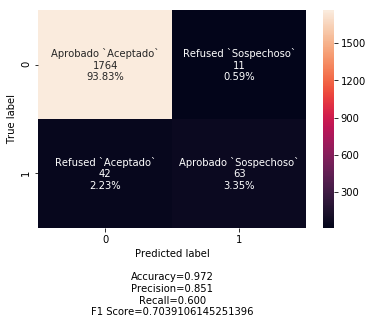

In [18]:

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [296]:
le=LabelEncoder()
le.fit(target)
#yt=le.transform(y_test)
#yp=le.transform(y_pred)
#f1_score(yt,yp)

LabelEncoder()

In [297]:
#f1_score(yt,yp)
from sklearn.metrics import f1_score
scorer=make_scorer(f1_score)
scores=cross_validate(estimator=model,X=features,y=le.transform(target),scoring=scorer,cv=5)
print(scores)
print('Promedio: {}'.format(scores['test_score'].mean()))

{'fit_time': array([1.7164073 , 1.650599  , 1.63166404, 1.62561989, 1.61869454]), 'score_time': array([0.00601602, 0.00598168, 0.00598121, 0.00598764, 0.00598907]), 'test_score': array([0.71276596, 0.71502591, 0.68181818, 0.65555556, 0.70526316]), 'train_score': array([1., 1., 1., 1., 1.])}
Promedio: 0.6940857518902067


In [ ]:
0.6863364052882338

Feature: EFECTIVO, Score: 0.02848073634337656
Feature: CXC, Score: 0.038645212411839595
Feature: INVENTARIO, Score: 0.08119395469177322
Feature: EQ_OFICINA, Score: 0.014136166871558255
Feature: EQ_TRANSPORTE, Score: 0.009058429126519475
Feature: TERRENOS_Y_CONSTRUCCIONES, Score: 0.21954726244701786
Feature: CXP, Score: 0.038047707867137175
Feature: CONTRIBUCIONES_X_PAGAR, Score: 0.009598835913980771
Feature: ANTICIPOS_CTE, Score: 0.04264291490188058
Feature: UTILIDADES_ACUMULADAS, Score: 0.08354510457321787
Feature: UTILIDAD_O_PERDIDA, Score: 0.30440475999242433
Feature: TOTAL_VENTAS, Score: 0.059491312567474364
Feature: TOTAL_COMPRAS, Score: 0.010330114954048009
Feature: UTILIDAD_BRUTA, Score: 0.06087748733775196


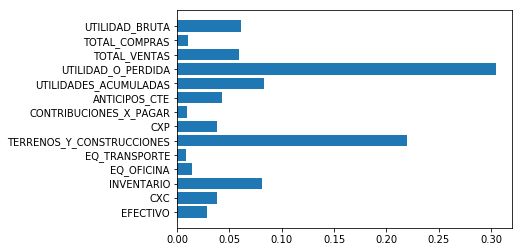

In [298]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: {}, Score: {}'.format(features.columns[i],v))
# plot feature importance
plt.barh([x for x in features.columns], importance)
plt.show()

##### ¡ATENCIÓN! Su puntuación en este desafío de clasificación se basará en la puntuación F1 del modelo.

<hr>

### Construcción del Pipeline completo para el encapsulamiento en WML

#### Preparando transformaciones personalizadas para cargar en WML

En el reto 2 (Tortuga Code), se mostró cómo crear una transformación personalizada, declarando una clase Python con los métodos ``fit`` y ``transform``.

    - Código de transformación personalizada DropColumns():
    
    from sklearn.base import BaseEstimator, TransformerMixin
    # All sklearn Transforms must have the `transform` and `fit` methods
    class DropColumns(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            # Primero copiamos el dataframe de entrada 'X' de entrada
            data = X.copy()
            # Devolvemos un nuevo marco de datos sin las columnas no deseadas
            return data.drop(labels=self.columns, axis='columns')

Para integrar estos tipos de transformaciones personalizadas con Pipelines en Watson Machine Learning, primero debe empaquetar su código personalizado como una biblioteca de Python. Esto se puede hacer fácilmente usando la herramienta *setuptools*.

En el siguiente repositorio de git: https://github.com/vnderlev/sklearn_transforms tenemos todos los archivos necesarios para crear un paquete de Python, llamado **my_custom_sklearn_transforms**.
Este paquete tiene la siguiente estructura de archivos:

    /my_custom_sklearn_transforms.egg-info
        dependency_links.txt
        not-zip-safe
        PKG-INFO
        SOURCES.txt
        top_level.txt
    /my_custom_sklearn_transforms
        __init__.py
        sklearn_transformers.py
    PKG-INFO
    README.md
    setup.cfg
    setup.py
    
El archivo principal, que contendrá el código para nuestras transformaciones personalizadas, es el archivo **/my_custom_sklearn_transforms/sklearn_transformers.py**. Si accedes a él en el repositorio, notarás que contiene exactamente el mismo código declarado en el primer paso (la clase DropColumns).

Si has declarado sus propias transformaciones (además de la DropColumn proporcionada), debes agregar todas las clases de esas transformaciones creadas en este mismo archivo. Para hacer esto, debes hacer fork de este repositorio (esto se puede hacer en la propia interfaz web de Github, haciendo clic en el botón como se muestra en la imagen a continuación) y agregue sus clases personalizadas al archivo **sklearn_transformers.py**.

![alt text](https://i.imgur.com/2lZ4Ty2.png "forking-a-repo")

Si solo hizo uso de la transformación proporcionada (DropColumns), puede omitir este paso de fork y continuar usando el paquete base provisto. :)

Después de preparar su paquete de Python con sus transformaciones personalizadas, reemplace el enlace del repositorio de git en la celda a continuación y ejecútelo. Si no ha preparado ninguna transformación nueva, ejecute la celda con el enlace del repositorio ya proporcionado.

<hr>
    
**OBSERVACIÓN**

Si la ejecución de la celda a continuación devuelve un error de que el repositorio ya existe, ejecute:

**!rm -r -f sklearn_transforms**

In [266]:
# Susbtituya el link de abajo por el link de su repositorio git (se es necesario)
!git clone https://github.com/vnderlev/sklearn_transforms.git

In [265]:
!pip install git

In [267]:
!cd sklearn_transforms
!ls -ltr

Para subir o código no WML, precisamos enviar um arquivo .zip com todo o código fonte, então iremos zipar o diretório clonado em seguida:

In [268]:
!zip -r sklearn_transforms.zip sklearn_transforms

Con el archivo zip de nuestro paquete cargado en el Kernel de este notebook, podemos utiliar la herramienta pip para instalarlo conforme a la siguiente celda:

In [269]:
!pip install sklearn_transforms.zip

Processing c:\users\bucanero2010\documents\sebastian\machine learning\maratona\reto 4\sklearn_transforms.zip


Ahora podemos realizar la importación de nuestro paquiete personalizado en nuestro notabook!

Vamos a importan la transformación DropColumns. Si usted posee otras transformaciones personalizadas, ahora es que debe importarlas

In [270]:
from my_custom_sklearn_transforms.sklearn_transformers import DropColumns

ModuleNotFoundError: No module named 'my_custom_sklearn_transforms'

## Construyendo el model Pipeline

# ATENCIÓN, NO CAMBIE LA CELDA DE ABAJO O SU MODELO NO SERA EVALUADO

In [230]:
pipeline_input = df[
    [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]

pipeline_target = df['OBJETIVO']

In [231]:
# Separación de los datos en un set de entrenamiento y otro de prueba (PARA CREACION DEL PIPELINE)
X_train, X_test, y_train, y_test = train_test_split(
    pipeline_input,
    pipeline_target,
    test_size=0.3,
    random_state=21233
)

In [207]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.combine import SMOTETomek

#sm = SMOTE(random_state = 2)
sm = SMOTETomek(random_state = 2)
#sm=RandomOverSampler(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())
X_train=pd.DataFrame(X_train)
X_train.columns=[
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
X_test=pd.DataFrame(X_test)
X_test.columns=[
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]

In [214]:
pd.Series(y_train).value_counts()

Sospechoso    7098
Aceptado      7098
dtype: int64

### Borrando las columnas del dataset original

Debe elminiar todas las columnas que no esta usando

In [232]:
# Creacion de la Transformación Personalizada ``DropColumns``

rm_columns = DropColumns(
    columns=[]
)

### Reemplazando con zeros en lugar de valores nulos

Ud puede usar otras estrategias, pero deben ser con Transforms

In [233]:
# Crear un objeto ``SimpleImputer``

si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='mean',  # la estrategia elegida es cambiar el valor faltante por una constante (Ejemplo)
    fill_value=0,  # la constante que se usará para completar los valores faltantes es un int64 = 0
    verbose=0,
    copy=True
)

### Estandarizando los valores numericos

In [234]:
sc = StandardScaler()

### Pre-entrenando el modelo para definir el pipeline

En la celda de abajo se declara un objeto **Pipeline** de scikit-learn, donde es declarado como parametros *steps*, que es una lista de etapas a ejecutar el pipeline:

    'paso_1_remove_cols'     - Transformación personalizada DropColumns
    'paso_2_imputer'         - Transformación embebida de scikit-learn para remplazar los valores faltantes
    'paso_3_standard_scaler'          - Transformación embebida de scikit-learn para escalar las variables numéricas
    'su_modelo'              - Un árbol de desición simple
    
Note que pasamos como pasos las transformaciones instanciadas anteriormente, con nombres `rm_columns` y `si`.

In [235]:
# Creación de nuestro para almacenamiento en Watson Machine Learning:
my_pipeline = Pipeline(
    steps=[
        ('paso_1_remove_cols', rm_columns),
        ('paso_2_imputer', si),
        ('paso_3_standard_scaler', sc),
        ('su_modelo', GradientBoostingClassifier(random_state=123,learning_rate=0.3,n_estimators=140,max_depth=5)),
        #('su_modelo',DecisionTreeClassifier(random_state=123,max_depth=20))
    ]
)

En seguida ejecutaremos el método `fit()` del Pipeline, realizando el pré-procesamiento y el entrenamiento del modelo de una sola vez.

In [236]:
# Inicializando el Pipeline (pre-procesamiento y entrenamiento del modelo)
my_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('paso_1_remove_cols', DropColumns(columns=[])), ('paso_2_imputer', SimpleImputer(copy=True, fill_value=0, missing_values=nan, strategy='mean',
       verbose=0)), ('paso_3_standard_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('su_modelo', GradientBoostingClassifier(cr...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.982\nPrecision=0.949\nRecall=0.999\nF1 Score=0.973')

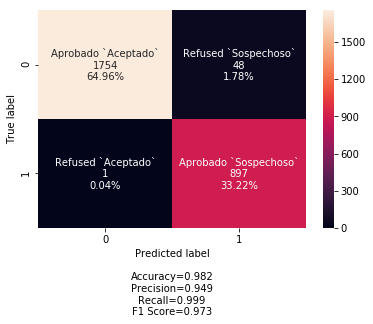

In [237]:
### Haciendo una predicción con el set de prueba

y_pred = my_pipeline.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [238]:
# Precisión simple
my_pipeline.score(X_test, y_test)

0.9818518518518519

In [240]:
!pip install watson_machine_learning_client

  Stored in directory: C:\Users\Bucanero2010\AppData\Local\pip\Cache\wheels\a7\10\5b\5d6543382dc5cc86022e490619c8db1253c22d50a57493262b
  Stored in directory: C:\Users\Bucanero2010\AppData\Local\pip\Cache\wheels\4d\69\e0\048f98aadb8f018f13fde51c52af878763eed47d2ee0fb735d
  Stored in directory: C:\Users\Bucanero2010\AppData\Local\pip\Cache\wheels\44\90\ce\c4fa6f55d3c3cfd1f824f31585c58cd717ef035a63620e7ba7
Successfully built ibm-cos-sdk ibm-cos-sdk-core ibm-cos-sdk-s3transfer


Ahora que tenemos un Pipeline completo, con etapas de pre-procesamiento configuradas y tambien un modelo por Árbol de Desición entrenado, podemos realizar la integración con Watson Machine Learning!

<hr>

### Encapsulando un Pipeline personalizado de Watson Machine Learning

#### Estableciendo conexión entre el cliente Python de WML y su instancia del servicio en la nube

In [241]:
# Biblioteca Python con implementación de un cliente HTTP para la API de WML

from watson_machine_learning_client import WatsonMachineLearningAPIClient

2020-08-27 18:27:42,812 - watson_machine_learning_client.wml_client_error - WARNING - Failure during creation of library.
Reason: The artifact specified ( sklearn_transforms.zip ) does not exist.


Las próximas celdas realizaran el despliegue del pipeline declarada en este notebook en WML. Solo prosiga si usted ya está satisfecho con su modelo y cree que ya es hora de hacer el despliegue de su solución.

Copie las credenciales de su instancia de Watson Machine Learning en la variable de la celda de abajo.

Es importante que la variable que contenga los valores de la credencial se llame ``wml_credentials`` para que las proximas celdas de este notebook se ejecuten corretamente.

In [242]:
wml_credentials = {
  "apikey": "SlDlt_ZVP22W95PWsg06XtkFfZmSQVCpFQI-Mvkv4rts",
  "iam_apikey_description": "Auto-generated for key ffe6dea4-ba79-4493-8789-f85d7a3611a7",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/a780b289d3ce45c0b0b1a79b7764c9d8::serviceid:ServiceId-28670fa5-b08c-4793-ab4e-4b7b40fd8b0a",
  "instance_id": "b9e3d10d-6fe5-4c9e-9d92-46d555559b44",
  "url": "https://us-south.ml.cloud.ibm.com"
}

In [243]:
# Instanciando un objeto cliente de Watson Machine Learning a partir de las credenciales

clientWML = WatsonMachineLearningAPIClient(wml_credentials)

In [244]:
# Extrayendo los detalles de su de Watson Machine Learning

instance_details = clientWML.service_instance.get_details()
print(json.dumps(instance_details, indent=4))

{
    "entity": {
        "source": "Bluemix",
        "published_models": {
            "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/b9e3d10d-6fe5-4c9e-9d92-46d555559b44/published_models"
        },
        "usage": {
            "capacity_units": {
                "current": 0,
                "limit": 180000000
            },
            "computation_time": {
                "current": 0,
                "limit": 180000
            },
            "deployment_count": {
                "current": 1,
                "limit": 5
            },
            "expiration_date": "2020-09-01T00:00:00.000Z",
            "gpu_count_k80": {
                "current": 0,
                "limit": 8
            },
            "gpu_count_p100": {
                "current": 0,
                "limit": 0
            },
            "gpu_count_v100": {
                "current": 0,
                "limit": 0
            },
            "model_count": {
                "current": 1,
         

**¡¡ATENCIÓN!!**

¡Este atento de los limites de consumo de su instancia de Watson Machine Learning!

En caso de que acabe la capa gratuita, no sera posible evualuar su modelo (Pues es necesario para la realización de algunas llamadasal API con sus predicciones!)

#### Listando todos los artefatos almacenados en su WML

Para listar todos los artefatos almacenados en su Watson Machine Learning, usted puede usar la seguinte función:

    clientWML.repository.list()

In [245]:
# Listando todos los artefatos actualmente almacenados en su instancia de WML

clientWML.repository.list()

------------------------------------  ----------------------------------  ------------------------  -----------------  -----------------
GUID                                  NAME                                CREATED                   FRAMEWORK          TYPE
bc4f423e-3323-4563-9042-443a7b4d0a6b  desafio-2-mbtc2020-pipeline-es-2    2020-08-27T22:55:33.370Z  scikit-learn-0.20  model
e4877a79-09a1-43eb-8ad2-ad9aa8ae2282  desafio-2-mbtc2020-deployment-es-2  2020-08-27T22:55:51.387Z  scikit-learn-0.20  online deployment
b480fc3f-b41b-4582-b070-17992a3c23ca  my_custom_sklearn_transform_es_2    2020-08-27T22:55:19.027Z  -                  python library
b9e44e78-0b4f-408e-bae5-fa6821c6a99b  my_custom_wml_runtime_es_1          2020-08-27T22:55:24.786Z  -                  python runtime
------------------------------------  ----------------------------------  ------------------------  -----------------  -----------------


## ATENCIÓN!, SI UD CORRE LAS CELDAS DE ABAJO TODOS LOS DESPLIEGUES ANTERIORS SERAN BORRADOS

In [246]:
#Celda para borrar los Deployments:

for uid in clientWML.deployments.get_uids():
    if clientWML.deployments.get_details(uid)['entity']['name'] == 'deployment_meta_4' : 
        print('Deleted ' + clientWML.deployments.get_details(uid)['entity']['name'] )
        clientWML.deployments.delete(uid)

In [247]:
#Celda para borrar todos los recursos:

d = clientWML.repository.get_details()
for k in d:
    for res in d[k]["resources"]:
        if res['entity']['name'] in ['package_meta_4', 'runtime_meta_4', 'pipeline_meta_4']:
            clientWML.repository.delete(res["metadata"]["guid"])
            print('Deleted ' + res['entity']['name'])

In [248]:
# Listando todos los artefatos actualmente almacenados en su instancia de WML

clientWML.repository.list()

------------------------------------  ----------------------------------  ------------------------  -----------------  -----------------
GUID                                  NAME                                CREATED                   FRAMEWORK          TYPE
bc4f423e-3323-4563-9042-443a7b4d0a6b  desafio-2-mbtc2020-pipeline-es-2    2020-08-27T22:55:33.370Z  scikit-learn-0.20  model
e4877a79-09a1-43eb-8ad2-ad9aa8ae2282  desafio-2-mbtc2020-deployment-es-2  2020-08-27T22:55:51.387Z  scikit-learn-0.20  online deployment
b480fc3f-b41b-4582-b070-17992a3c23ca  my_custom_sklearn_transform_es_2    2020-08-27T22:55:19.027Z  -                  python library
b9e44e78-0b4f-408e-bae5-fa6821c6a99b  my_custom_wml_runtime_es_1          2020-08-27T22:55:24.786Z  -                  python runtime
------------------------------------  ----------------------------------  ------------------------  -----------------  -----------------


#### Creando una nueva definición de paquete Python personalizado en WML

El primer paso para realizar su deploy y almacenar el código de las transformaciones personalizadas creadas por usted.

Para esta etapa solo necesitamos el archivo .zip del paquete creado por usted (Que ya tenemos cargados en el Kernel!)

In [249]:
# Definición de metadatos del paquete con las Transformaciones personalizadas
pkg_meta = {
    clientWML.runtimes.LibraryMetaNames.NAME: "package_meta_4",
    clientWML.runtimes.LibraryMetaNames.DESCRIPTION: "A custom sklearn transform package",
    clientWML.runtimes.LibraryMetaNames.FILEPATH: "sklearn_transforms.zip",  # Note que estamos utilizando o .zip criado anteriormente!
    clientWML.runtimes.LibraryMetaNames.VERSION: "1.0",
    clientWML.runtimes.LibraryMetaNames.PLATFORM: { "name": "python", "versions": ["3.6"] }
}
custom_package_details = clientWML.runtimes.store_library( pkg_meta )
custom_package_uid = clientWML.runtimes.get_library_uid( custom_package_details )

print("\n Lista de artefactos de runtime almacenados en WML:")
clientWML.repository.list()

WMLClientError: Failure during creation of library.
Reason: The artifact specified ( sklearn_transforms.zip ) does not exist.

#### Creando una nueva definición de runtime Python personalizado en WML

El segundo paso es almacenar una definición de runtime Python para utilizar en nuestra biblioteca personalizada.

Esto puede hacerse de la siguiente manera:

In [250]:
runtime_meta = {
    clientWML.runtimes.ConfigurationMetaNames.NAME: "runtime_meta_4",
    clientWML.runtimes.ConfigurationMetaNames.DESCRIPTION: "A Python runtime with custom sklearn Transforms",
    clientWML.runtimes.ConfigurationMetaNames.PLATFORM: {
        "name": "python",
        "version": "3.6"
    },
    clientWML.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS: [ custom_package_uid ]
}
runtime_details = clientWML.runtimes.store( runtime_meta )
custom_runtime_uid = clientWML.runtimes.get_uid( runtime_details )

print("\n Detalles del runtime almacenados:")
print(json.dumps(runtime_details, indent=4))

NameError: name 'custom_package_uid' is not defined

In [ ]:
# Listando todos los runtimes almacenados en su WML:
clientWML.runtimes.list()

#### Creando una nueva definición de Pipeline personalizado en WML

Finalmente creando una definición (metadatos) para que nuestro Pipeline sea hospedada en WML.

Definimos como parametros el nombre para el artefacto y el ID de runtime creado anteriormente.

In [ ]:
model_meta = {
    clientWML.repository.ModelMetaNames.NAME: 'pipeline_meta_4',
    clientWML.repository.ModelMetaNames.DESCRIPTION: "my pipeline for submission",
    clientWML.repository.ModelMetaNames.RUNTIME_UID: custom_runtime_uid
}

En seguida llamamos el método para almacenar una nueva definición:

In [ ]:
# Función para almacenar una definición de Pipeline en WML
stored_model_details = clientWML.repository.store_model(
    model=my_pipeline,  # `my_pipeline` es la variable creada anteriormente que contiene nuestro Pipeline ya entrenado :)
    meta_props=model_meta,  # Metadatos definidos en la celda anterior
    training_data=None  # No altere este parametro
)

print("\n Lista de artefatos almacenados en WML:")
clientWML.repository.list()

# Datalles del modelo hospedado en Watson Machine Learning
print("\n Metadatos del modelo almacenado:")
print(json.dumps(stored_model_details, indent=4))

#### Realizando un deployment de su modelo para consumo inmediato por otras aplicaciones

In [ ]:
# El deployment del modelo es finalmente realizado por medio del método ``deployments.create()``

model_deployment_details = clientWML.deployments.create(
    artifact_uid=stored_model_details["metadata"]["guid"],  # No altere este parametro
    name="deployment_meta_4",
    description="Desafio 4 MBTC",
    asynchronous=False,  # No altere este parametro
    deployment_type='online',  # No altere este parametro
    deployment_format='Core ML',  # No altere este parametro
    meta_props=model_meta  # No altere este parametro
)

#### Probando el modelo hospedado en Watson Machine Learning

In [ ]:
# Recuperando la URL endpoint dl modelo hospedado en la celda anterior

model_endpoint_url = clientWML.deployments.get_scoring_url(model_deployment_details)
print("La URL de llamada de su API es: {}".format(model_endpoint_url))

### ATENCIÓN: UD necesitará de la URL de arriba para entregar su modelo :)

In [ ]:
# Detalles del deployment realizado

deployment_details = clientWML.deployments.get_details(
    deployment_uid=model_deployment_details["metadata"]["guid"]  # Este es el ID de su deployment!
)

print("Metadatos del deployment realizado: \n")
print(json.dumps(deployment_details, indent=4))

### Realizando una llamada de API para su modelo almacenado en WML

In [ ]:
scoring_payload = {
    'fields': [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ],
    'values': [
        [
            968866.8993,
            102102.000,
            8539205.63,
            3898282.548,
            416873.3265,
            1420050.089,
            -629717.8548,
            14613560.64,
            7620711.462,
            116647.7396,
            1798064.624,
            9535423.826,
            3657339.603,
            770284.5004,
            -102101.201,
            -711032.0155
        ]
    ]
}

print("\n Payload de datos a ser clasificado:")
print(json.dumps(scoring_payload, indent=4))

In [ ]:
result = clientWML.deployments.score(
    model_endpoint_url,
    scoring_payload
)

print("\n Resultados:")
print(json.dumps(result, indent=4))

<hr>

## ¡Felicitaciones! 

Si todo fue ejecutado sin errores, ¡usted ya tiene un predictor basado en clasificacíon binaria encapsulado como una API REST!

Para enviar su solución, accede a la página:

# https://compusoluciones.maratona.dev

Usted necesitará del endpoint url de su modelo y las credenciales de WML :)